## **Import Some Basic Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import copy as cp
import cv2

# Visualizations's libs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Modeling used libs
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM

from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#from keras.applications import DenseNet121



# Avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setting up the colors for the output
colors = {'good':'green', 'bad':'red', 'scratch':'blue','ink':'yellow'}

/kaggle/input/wafersdata/df_wafers.csv
/kaggle/input/wafersdata/df_wafers_head.csv
/kaggle/input/wafersdata/df_wafers_test.csv
/kaggle/input/wafersdata/df_wafers_test_head.csv


## **Reading the Training Data and understanding the attributes**

In [2]:
# reading the training data
training_data = pd.read_csv('../input/wafersdata/df_wafers_head.csv')
training_df = pd.DataFrame(training_data)

#readiing the testing data
testing_data = pd.read_csv('../input/wafersdata/df_wafers_test_head.csv')
testing_df = pd.DataFrame(testing_data)

# getting the shape of the training data
# we have 16772092 rows (including duplicates) and 5 columns
print(training_data.shape[0]," rows of wafers' trainng data and ",training_data.shape[1], "columns")

# Show the training data's columns' names
print("The training data's columns' names: ", training_df.columns.values)

# we have 3920 wafers' data in our training data
print((training_df["WaferName"].unique()).shape[0]," wafers' data in our training data")

# getting the shape of the testing data
# we have 1860063 rows (including duplicates) and 4 columns
print(testing_data.shape[0]," rows of wafers' testing data and ",testing_data.shape[1], "columns")

# Show the testing data's columns' names
print("The testing data's columns' names: ", testing_df.columns.values)

# we have 439 wafers' data in our testing data
print((testing_df["WaferName"].unique()).shape[0]," wafers' data in our testing data")

3015  rows of wafers' trainng data and  5 columns
The training data's columns' names:  ['WaferName' 'DieX' 'DieY' 'IsGoodDie' 'IsScratchDie']
3  wafers' data in our training data
9045  rows of wafers' testing data and  4 columns
The testing data's columns' names:  ['WaferName' 'DieX' 'DieY' 'IsGoodDie']
9  wafers' data in our testing data


### Reading the head of the data sets

In [3]:
print("Training Set's Head\n")
training_data.head()

Training Set's Head



,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,False,False
1,3b2e28,0,13,True,False
2,3b2e28,0,14,False,False
3,3b2e28,0,15,True,False
4,3b2e28,0,16,True,False


In [4]:
print("Testing Set's Head\n")
testing_data.head()

Testing Set's Head



,WaferName,DieX,DieY,IsGoodDie
0,5a6ad6,0,12,False
1,5a6ad6,0,13,True
2,5a6ad6,0,14,True
3,5a6ad6,0,15,True
4,5a6ad6,0,16,True


## Check for wafers' dimensions

In [5]:
print("Training set's wafers' dimensions: \n")
training_dim_x = (training_df.groupby(['WaferName'])['DieX'].max()+1).reset_index(name='dimX')
training_dim_y = (training_df.groupby(['WaferName'])['DieY'].max()+1).reset_index(name='dimY')
train_dim = pd.merge(training_dim_x, training_dim_y, on='WaferName')
print(train_dim)
if (train_dim.query("dimX != dimY")).empty:
    print("All the wafers from training data are square")
print("Max and min dims are: ",train_dim['dimX'].max(),train_dim['dimX'].min())
print("Most common dim: \n",(train_dim['dimX'].value_counts()).head())
print("Mean dim is: \n",(train_dim['dimX'].mean()))
print("\n")

print("Test set's wafers' dimensions:\n")
testdim_x = (testing_df.groupby(['WaferName'])['DieX'].max()+1).reset_index(name='dimX')
testdim_y = (testing_df.groupby(['WaferName'])['DieY'].max()+1).reset_index(name='dimY')
test_dim = pd.merge(testdim_x, testdim_y, on='WaferName')
print(test_dim)
if (test_dim.query("dimX != dimY")).empty:
    print("All the wafers from testing data are square")
print("Max and min dims are: ",test_dim['dimX'].max(),test_dim['dimX'].min())
print("Most common dim:\n",(test_dim['dimX'].value_counts()).head())
print("Mean dim is: \n",(test_dim['dimX'].mean()))
MEAN_DIM=100
#MEAN_DIM = int((train_dim['dimX'].mean()+test_dim['dimX'].mean())/2)

Training set's wafers' dimensions: 

  WaferName  dimX  dimY
0    3b2e28    35    35
1    97a213    35    35
2    e412b6    35    35
All the wafers from training data are square
Max and min dims are:  35 35
Most common dim: 
 35    3
Name: dimX, dtype: int64
Mean dim is: 
 35.0


Test set's wafers' dimensions:

  WaferName  dimX  dimY
0    01913a    35    35
1    179b32    35    35
2    1baf11    35    35
3    342886    35    35
4    4dd3dd    35    35
5    5219a1    35    35
6    5a6ad6    35    35
7    988551    35    35
8    ea85bd    35    35
All the wafers from testing data are square
Max and min dims are:  35 35
Most common dim:
 35    9
Name: dimX, dtype: int64
Mean dim is: 
 35.0


### Check for Null values

In [6]:
# Checking if the dataset contains any NULL values
print(training_data.isnull().any().any(),"\n")
# Checking if the dataset contains any NULL values
print(testing_data.isnull().any().any())

False 

False


## **Summarizing some statistics regarding the wafers**

### **Statistics: Good or Bad dies from training data**

In [7]:
training_df_good_dies = training_df.groupby(['WaferName', 'IsGoodDie']).size().reset_index(name='Count')

filtered_df1 = training_df_good_dies.query('IsGoodDie')
filtered_df1 = filtered_df1.drop(columns='IsGoodDie')
filtered_df1 = filtered_df1.sort_values(by='Count', ascending=False)
filtered_df11 = filtered_df1.reset_index().rename(columns={'Count': 'GoodDiesCount'})

print(filtered_df11.head(),'\n')

filtered_df2 = training_df_good_dies.query('~IsGoodDie')
filtered_df2 = filtered_df2.drop(columns='IsGoodDie')
filtered_df2 = filtered_df2.sort_values(by='Count', ascending=False)
filtered_df22 = filtered_df2.reset_index().rename(columns={'Count': 'BadDiesCount'})
print(filtered_df22.head(),'\n')

organized_filtered_df = pd.merge(filtered_df11, filtered_df22, on='WaferName')
organized_filtered_df = organized_filtered_df.drop(columns=['index_x','index_y'])
organized_filtered_df['BadDiesRatio(%)'] = (organized_filtered_df['BadDiesCount']/(organized_filtered_df['BadDiesCount']+organized_filtered_df['GoodDiesCount'])*100)
organized_filtered_df = organized_filtered_df.sort_values(by='BadDiesRatio(%)', ascending=False)
print(organized_filtered_df.head(),'\n')

   index WaferName  GoodDiesCount
0      3    97a213            921
1      1    3b2e28            910
2      5    e412b6            910 

   index WaferName  BadDiesCount
0      0    3b2e28            95
1      4    e412b6            95
2      2    97a213            84 

  WaferName  GoodDiesCount  BadDiesCount  BadDiesRatio(%)
1    3b2e28            910            95         9.452736
2    e412b6            910            95         9.452736
0    97a213            921            84         8.358209 



### **Statistics: Sctrached or none scratched dies from training data**

In [8]:
training_df_sc_dies = training_df.groupby(['WaferName', 'IsScratchDie']).size().reset_index(name='ScratchedDiesCount')

filtered_sc_df1 = training_df_sc_dies.query('IsScratchDie')
filtered_sc_df1 = filtered_sc_df1.drop(columns='IsScratchDie')
filtered_sc_df1 = filtered_sc_df1.sort_values(by='ScratchedDiesCount', ascending=False)
filtered_sc_df11 = filtered_sc_df1.reset_index().rename(columns={'Count': 'ScratchedDiesCount'})

print(filtered_sc_df11.head(),'\n')

filtered_sc_df2 = training_df_sc_dies.query('~IsScratchDie')
filtered_sc_df2 = filtered_sc_df2.drop(columns='IsScratchDie')
filtered_sc_df2 = filtered_sc_df2.sort_values(by='ScratchedDiesCount', ascending=False)
filtered_sc_df22 = filtered_sc_df2.reset_index().rename(columns={'ScratchedDiesCount': 'NoneScratchedDiesCount'})
print(filtered_sc_df22.head(),'\n')

organized_filtered_sc_df = pd.merge(filtered_sc_df11, filtered_sc_df22, on='WaferName')
organized_filtered_sc_df = organized_filtered_sc_df.drop(columns=['index_x','index_y'])
organized_filtered_sc_df['ScratchedDiesRatio(%)'] = (organized_filtered_sc_df['ScratchedDiesCount']/(organized_filtered_sc_df['ScratchedDiesCount']+organized_filtered_sc_df['NoneScratchedDiesCount'])*100)
organized_filtered_sc_df = organized_filtered_sc_df.sort_values(by='ScratchedDiesRatio(%)', ascending=False)
print(organized_filtered_sc_df.head(),'\n')

   index WaferName  ScratchedDiesCount
0      5    e412b6                  27
1      1    3b2e28                  25
2      3    97a213                  17 

   index WaferName  NoneScratchedDiesCount
0      2    97a213                     988
1      0    3b2e28                     980
2      4    e412b6                     978 

  WaferName  ScratchedDiesCount  NoneScratchedDiesCount  ScratchedDiesRatio(%)
0    e412b6                  27                     978               2.686567
1    3b2e28                  25                     980               2.487562
2    97a213                  17                     988               1.691542 



### **Statistics: Good or Bad dies from testing data**

In [9]:
testing_df_good_dies = testing_df.groupby(['WaferName', 'IsGoodDie']).size().reset_index(name='Count')

filtered_test_df1 = testing_df_good_dies.query('IsGoodDie')
filtered_test_df1 = filtered_test_df1.drop(columns='IsGoodDie')
filtered_test_df1 = filtered_test_df1.sort_values(by='Count', ascending=False)
filtered_test_df11 = filtered_test_df1.reset_index().rename(columns={'Count': 'GoodDiesCount'})

print(filtered_test_df11.head(),'\n')

filtered_test_df2 = testing_df_good_dies.query('~IsGoodDie')
filtered_test_df2 = filtered_test_df2.drop(columns='IsGoodDie')
filtered_test_df2 = filtered_test_df2.sort_values(by='Count', ascending=False)
filtered_test_df22 = filtered_test_df2.reset_index().rename(columns={'Count': 'BadDiesCount'})
print(filtered_test_df22.head(),'\n')

organized_filtered_test_df = pd.merge(filtered_test_df11, filtered_test_df22, on='WaferName')
organized_filtered_test_df = organized_filtered_test_df.drop(columns=['index_x','index_y'])
organized_filtered_test_df['BadDiesRatio(%)'] = (organized_filtered_test_df['BadDiesCount']/(organized_filtered_test_df['BadDiesCount']+organized_filtered_test_df['GoodDiesCount'])*100)
organized_filtered_test_df = organized_filtered_test_df.sort_values(by='BadDiesRatio(%)', ascending=False)
print(organized_filtered_test_df.head(),'\n')

   index WaferName  GoodDiesCount
0      9    4dd3dd            927
1     17    ea85bd            924
2     13    5a6ad6            923
3      5    1baf11            919
4     11    5219a1            917 

   index WaferName  BadDiesCount
0      0    01913a            94
1     14    988551            91
2      2    179b32            89
3      6    342886            89
4     10    5219a1            88 

  WaferName  GoodDiesCount  BadDiesCount  BadDiesRatio(%)
8    01913a            911            94         9.353234
7    988551            914            91         9.054726
5    179b32            916            89         8.855721
6    342886            916            89         8.855721
4    5219a1            917            88         8.756219 



## **Data Visualization**

### **Transforming Images**

In [10]:
TRAIN_FLAG = 0
TEST_FLAG = 1
class Data_Handler():
   #This class has basic data handler functions, used to exact data for our model
    def __init__(self, data, dimdata, train_test_flag):
        self.data = data
        self.dimdata = dimdata
        self.unique_wf_names = data[['WaferName']].drop_duplicates()
        self.X = None
        self.scratchX = None
        self.train_test_flag=train_test_flag

    def extract_image(self, wf_name):
      # extract dies of wafer from data set
      # 0 is false and 1 is true
        wf_dim = self.dimdata[self.dimdata["WaferName"]==wf_name]['dimX'].values[0]
        image=[[0 for _ in range(wf_dim)] for _ in range(wf_dim)] 
        wf_table = self.data[self.data["WaferName"]== wf_name]
        for i, item in wf_table.iterrows():
            image[item[1]][item[2]]=int(item[3])
        return image
    
    def extract_scratch_image(self, wf_name):
      # extract scratching info of wafer from data set
      # 0 is false and 1 is true
        wf_dim_line = self.dimdata[self.dimdata["WaferName"]==wf_name]['dimX']
        if wf_dim_line.empty:
            return None
        wf_dim = wf_dim_line.values[0]
        image=[[0 for _ in range(wf_dim)] for _ in range(wf_dim)] 
        wf_table = self.data[self.data["WaferName"]== wf_name]
        for i, item in wf_table.iterrows():
            image[item[1]][item[2]]=int(item[4])
        return image
    
    def denoise(self, image):
          #1. resize image to 21*21
          #2. reduce noise
        resized_image1 = np.array(image,dtype='uint8')
        resized_image = cv2.resize(resized_image1, (MEAN_DIM, MEAN_DIM), interpolation = cv2.INTER_AREA)
        return resized_image

    def insert_data(self,):
          #1. resize all image in training data into same size
          #2. one-hot encoding labels
        X = dict()
        scratchX = dict()
        for wf in self.unique_wf_names['WaferName']:
            image = self.extract_image(wf)
            image = self.denoise(image)
            X[str(wf)]=image
            if (self.train_test_flag==TRAIN_FLAG):
                scratch_image = self.extract_scratch_image(wf)
                scratch_image = self.denoise(scratch_image)
                scratchX[str(wf)]=scratch_image 
        self.X = X
        self.scratchX = scratchX
        #self.X = np.array(X).astype(np.float32) / 255.0  # normalize images
        #self.scratchX = np.array(scratchX).astype(np.float32) / 255.0  # normalize images

    def add_channel(self, x):
        #1. add channel to images
        return np.expand_dims(x, axis=3)
    
    # train 0, test 1
    def plot_image(self, wf_name):
        image = self.X[str(wf_name)]
        if (self.train_test_flag==TRAIN_FLAG):
            image = self.scratchX[wf_name]
        plt.imshow(image, cmap="copper_r")
        plt.show()
        
    def plot_image_list(self,wf_names_list):
        for wf_name in wf_names_list:
            self.plot_image(str(wf_name))

**Data testing**

In [11]:
tr = cp.deepcopy(training_df)
train = Data_Handler(tr,train_dim, TRAIN_FLAG)
train.insert_data()

ts = cp.deepcopy(testing_df)
test = Data_Handler(ts, test_dim, TEST_FLAG)
test.insert_data()

### **Print the top 4 wafers with greatest bad dies and scratched dies ratio from training data**

Ploting top wafers with greatest bad dies ratio



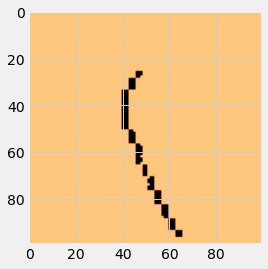

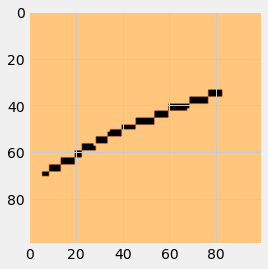

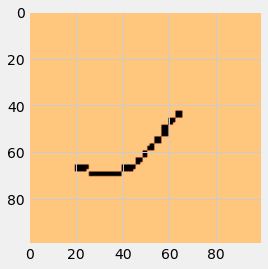

Ploting top wafers with greatest scratched dies ratio



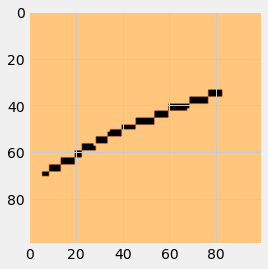

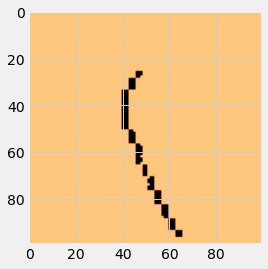

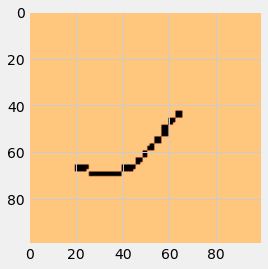

In [12]:
print("Ploting top wafers with greatest bad dies ratio\n")
curr_names=(organized_filtered_df.head())['WaferName']
train.plot_image_list(curr_names)

print("Ploting top wafers with greatest scratched dies ratio\n")
curr_names=(organized_filtered_sc_df.head())['WaferName']
train.plot_image_list(curr_names)

### **Print the top 4 wafers with gratest scratched dies ratio**

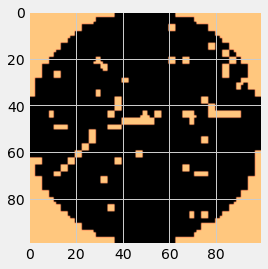

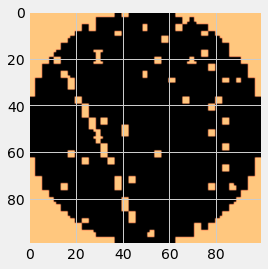

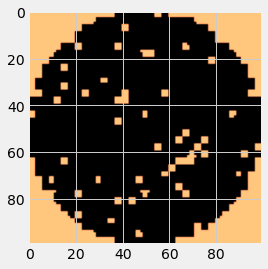

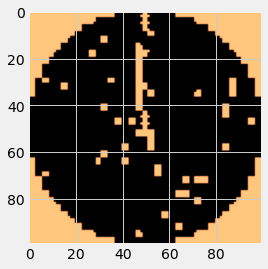

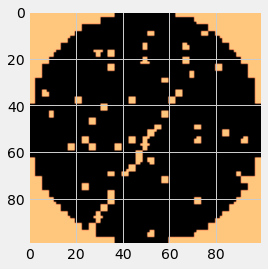

In [13]:
curr_names=(organized_filtered_test_df.head())['WaferName']
test.plot_image_list(curr_names)